# Scaling of Mutational Drift with Alphabet Size and non-equilibrium.

(c) 2020 Tom Röschinger. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

***

In this notebook we study the following relation:

$m^\Gamma = -\frac{n}{n-1}\mu(1+\kappa)(\Gamma-\Gamma_0)$

To prove this result, we are going to study the time evolution of the mean energy in the absence of fitness,

$\dot \Gamma = m^\Gamma$.

This differential equation has a analytic solution for $\Gamma(t)$,

$\Gamma(t) = \Gamma_0 + (\Gamma_i - \Gamma_0)\exp\left[-\frac{n}{n-1} \mu (1+\kappa)\,t \right]$.

Therefore, we are going to compute the time course of the mean energy for several parameters and compare it to the prediction.

In [2]:
using Jevo, Distributions, Jedi, Plots, LinearAlgebra, Distributed, SharedArrays, Turing, Measures, LaTeXStrings, JLD

# Set plotting style
Jedi.default_gr!()

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-8417699753834903486\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-11037821246831894868\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-8417699753834903486\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

Plots.GRBackend()

Initiate parallel computing (4 cores). Then import packages to all workers. We did load the packages in the initial worker first to ensure that the import works without error.

In [3]:
addprocs(4-nprocs())
@everywhere begin
    using Jevo, Distributions, LinearAlgebra, Plots, SharedArrays
end

Let's define the main function for the simulation.

In [4]:
@everywhere function run(rho, N, f, l0, generations, n)
    # Initiate the population.
    pop = Jevo.driver_trailer(N=N, L=l0, l=l0, n=n, m=n)
    emat::Array{Float64, 2} = ϵ * (ones(n,n) - Matrix{Float64}(I, n, n))
    Jevo.initiate!(pop, emat)
    
    # Arrays to store mean and variance at each generation 
    mean_array = zeros(Float64, generations)
    var_array = zeros(Float64, generations)
    for j in 1:generations
        # Trailer mutations
        for m in 1:rand(Poisson(.1), 1)[1]
            Jevo.mutation!(pop)
        end
        # Driver mutations
        for m in 1:rand(Poisson(rho / (10N)), 1)[1]
            Jevo.driver_mutation!(pop)
        end
        # Sample new generation
        Jevo.sample_gen!(pop, f, emat; remove=true)
        # Store mean and variance
        mean_array[j] = sum(Jevo.get_energy(pop, emat) .* pop.freqs) / pop.N
        var_array[j] = sum((Jevo.get_energy(pop, emat) .- mean_array[j]).^2 .* pop.freqs) / pop.N
    end
    return mean_array, var_array
end

Let's implement the time course prediction and the maximal number of generations and some additional parameters.

In [5]:
theory(n, rho, N, l, t_max) = ϵ*l * (n-1)/n .* (1 .- exp.(-.1/(N*l) * (n/(n-1) * (1+rho)) .* collect(0:t_max)))

@everywhere begin
    t_max = 50000
    N = 100
    f = Jevo.fermi_fitness(f0=0)
    ϵ = 2
end

Before we can run the simulation, we need to define the arrays in which the results are stored, as well as the parameters which are used in each iteration of the simulation.

In [6]:
n_arr = 2:13 |> collect
rho_arr = [0, 0.5, 1, 5];

Finally we can run the simulation and store the parameters in the shared arrays.

In [7]:
Gamma_arr = SharedArray{Float64, 3}(12, 4, t_max)
Delta_arr = SharedArray{Float64, 3}(12, 4, t_max)



@sync @distributed for k in 1:12
    n = n_arr[k]
    for (i, rho) in enumerate(rho_arr)
        gamma = Vector{Array{Float64, 1}}(undef, 100)
        delta = Vector{Array{Float64, 1}}(undef, 100)

        for j in 1:100 
            gamma[j], delta[j] = run(rho, N, f, 10, t_max, n)
        end
        Gamma_arr[k, i, :] = mean(gamma)
        Delta_arr[k, i, :] = mean(delta)
    end
end

Task (done) @0x0000000150b47190

Store the data.

In [8]:
JLD.save(
    "mutational_drift_simulation.jld", 
    "Gamma", 
    convert(Array{Float64, 3}, Gamma_arr), 
    "Delta", 
    convert(Array{Float64, 3}, Delta_arr)
)

Load the data for plotting.

In [9]:
drift_sim = JLD.load("mutational_drift_simulation.jld")
Γ_arr = drift_sim["Gamma"]
Δ_arr = drift_sim["Delta"];

Let's plot the time evolution of mean and variance over time. Therefore, we iterate through the used parameters and read out the shared arrays.

In [10]:
p = []
for i in 1:2:7
    p1 = plot(
        title="n = $(n_arr[i])", 
        xlabel="generations", 
        ylabel=L"$\Gamma$", 
        yticks=[0, 5, 10, 15], 
        minorticks=true, 
        grid=true,
        gridcolor="white",
        gridlinewidth=2,
        minorgrid=true,
        minorgridlinewidth=1.5,
        minorgridcolor="white",
        xticks=(collect(0:100:500), collect(0:100:500).*100),
        #xaxis=:log,
        #yaxis=:log
        
    )
    p2 = plot(
        xlabel="generations", 
        ylabel=L"$\Delta$", 
        yticks=[0, 0.5, 1, 1.5], 
        minorticks=true, 
        ylims=(0, 1.5),
        grid=true,
        gridcolor="white",
        gridlinewidth=2,
        minorgrid=true,
        minorgridlinewidth=1.5,
        minorgridcolor="white",
        xticks=(collect(0:100:500), collect(0:100:500).*100)
    )
    for j in 1:4
        prediction = theory(n_arr[i], rho_arr[j], 100, 10, t_max)
        plot!(p1, Γ_arr[i, j, 2:100:50000], color=palette(:seaborn_colorblind)[j], )
        plot!(p1, prediction[2:100:50000], color=palette(:seaborn_colorblind)[j], linestyle=:dash)
        plot!(p2, Δ_arr[i, j, 1:100:50000], color=palette(:seaborn_colorblind)[j])
    end
    push!(p, plot(p1,p2, size=(500, 250)))
end      

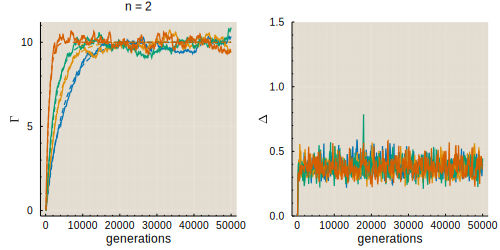

In [11]:
p[1]

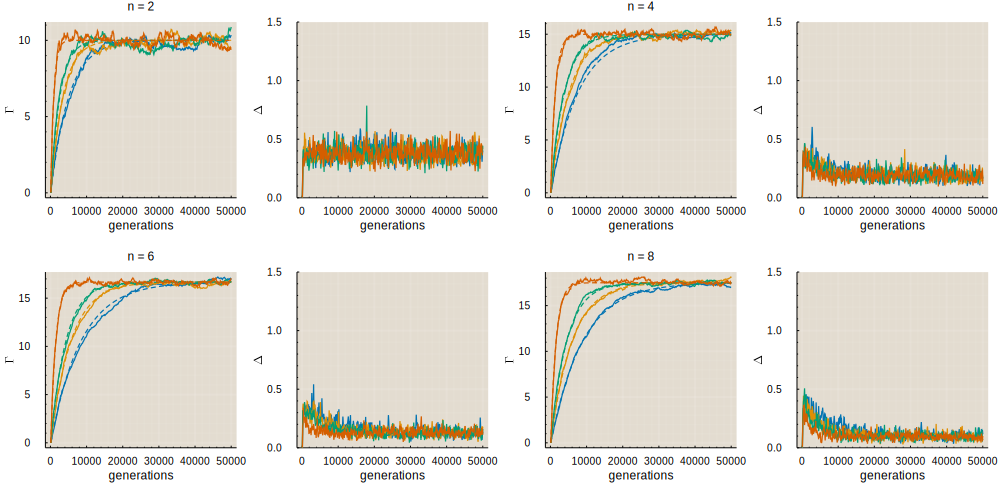

In [12]:
p_sim_results = plot(p..., bottom_margin=5mm, size=(1000, 500))
p_sim_results

In [13]:
savefig(p_sim_results, "../figures/drift_scaling_n_rho.pdf")

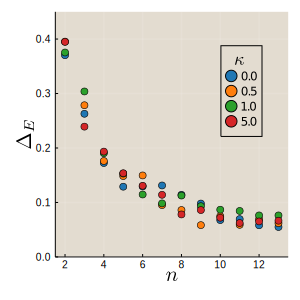

In [18]:
p_var = plot(
    xlabel=L"n", 
    ylabel=L"$\Delta_E$", 
    xticks=collect(2:2:13), 
    labelfontsize=14, 
    xlims=(1.5, 13.5), 
    ylims=(0, 0.45),
    legendtitle=L"$\kappa$",
    legendtitlefontsize=12
)
for i in 1:12
    for j in 1:4
        scatter!(p_var, [i+1], [mean(Delta_arr[i, j, end-1000:end])], color=palette(:tab10)[j])#, markershape=marker)
    end
end

# Add Legend
for j in 1:4
    scatter!(p_var, [-1], [-1], color=palette(:tab10)[j], label="$(rho_arr[j])")#, markershape=marker)
end

plot(p_var, size=(300, 300))

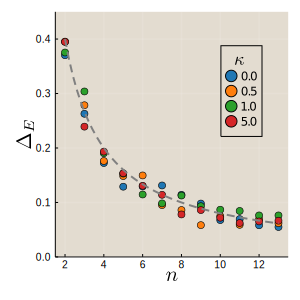

In [19]:
y_theory = ϵ^2*0.1 * [(2-x)/(x) + 1 for x in 2:0.2:13]
plot!(p_var, 2:0.2:13, y_theory, color="gray", linestyle=:dash, linewidth=2)
p_var = plot(p_var, size=(300, 300))

In [20]:
savefig(p_var, "../figures/variance_scaling_n.pdf")

In [21]:
using Pkg
Pkg.status("Jedi")
Pkg.status("Jevo")
Pkg.status("Distributions")
Pkg.status("Plots")
Pkg.status("Turing")
Pkg.status("Measures")

Status `~/.julia/environments/v1.5/Project.toml`
  [b681c197] Jedi v0.1.0 `../../../git/Jedi.jl`
Status `~/.julia/environments/v1.5/Project.toml`
  [49da04e1] Jevo v0.1.0 `../../../git/Jevo.jl`
Status `~/.julia/environments/v1.5/Project.toml`
  [31c24e10] Distributions v0.24.6
Status `~/.julia/environments/v1.5/Project.toml`
  [91a5bcdd] Plots v1.9.1
Status `~/.julia/environments/v1.5/Project.toml`
  [fce5fe82] Turing v0.15.4
Status `~/.julia/environments/v1.5/Project.toml`
  [442fdcdd] Measures v0.3.1
